In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

In [2]:
import tensorflow_datasets as tfds

ds, ds_info = tfds.load(
    "food101", shuffle_files=True, as_supervised=True, with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteOS7O2D/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteOS7O2D/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
train_ds, valid_ds = ds["train"], ds["validation"]

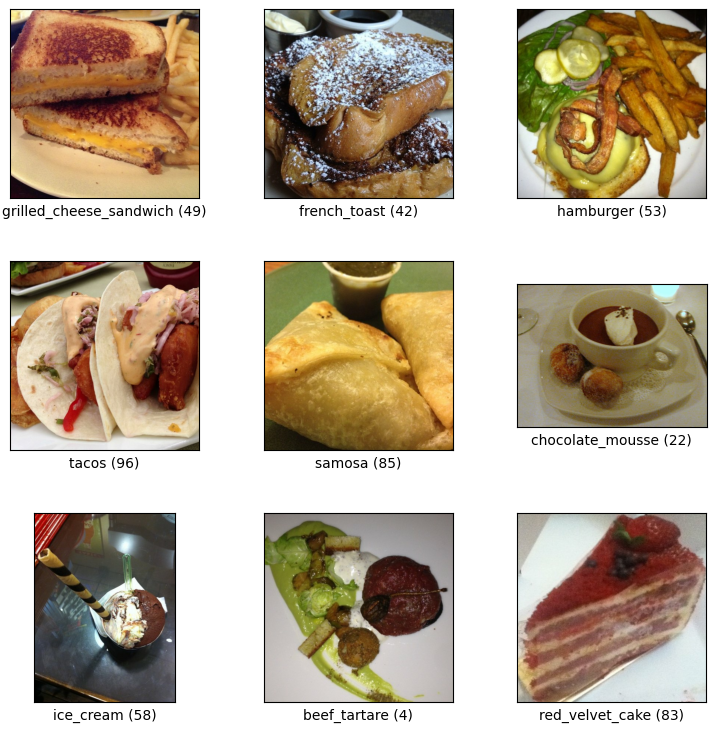

In [4]:
fig = tfds.show_examples(train_ds, ds_info)

In [5]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55


def preprocess_image(image, label):
    image = tf.cast(
        tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32
    )
    label = tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32)
    return image, label


train_ds = train_ds.map(preprocess_image)
valid_ds = valid_ds.map(preprocess_image)

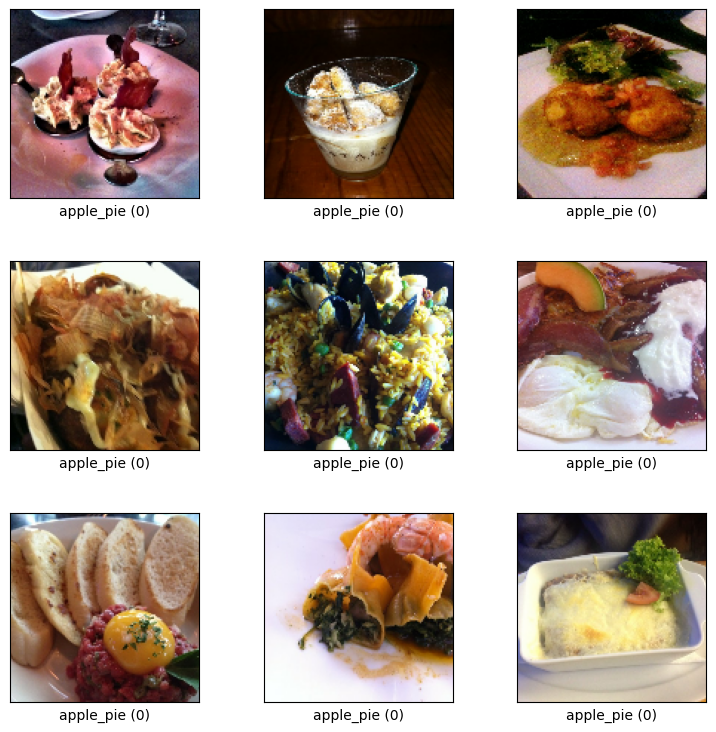

In [6]:
fig = tfds.show_examples(train_ds, ds_info)

In [7]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [8]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [9]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets(
    [train_hotdogs, train_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True
)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.sample_from_datasets(
    [valid_hotdogs, valid_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True
)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [10]:
for image, label in train_ds.take(3):
    print(image[0][0][0])
    print(label)

tf.Tensor([21 25 30], shape=(3,), dtype=int32)
tf.Tensor([1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0], shape=(16,), dtype=int32)
tf.Tensor([23 23 15], shape=(3,), dtype=int32)
tf.Tensor([1 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0], shape=(16,), dtype=int32)
tf.Tensor([177 181 182], shape=(3,), dtype=int32)
tf.Tensor([1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 1], shape=(16,), dtype=int32)


# Neural Network implementation

In [11]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

In [12]:
random.seed(0)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(1.0 / 255))
model.add(
    tf.keras.layers.Conv2D(
        128, (3, 3), activation="relu", input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)
    )
)
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(
    tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
    )
)
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(
    tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
    )
)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1))

In [13]:
lr = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [14]:
epochs = 50
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs, verbose=1)

Epoch 1/50
286/286 [==============================] - 470s 2s/step - loss: 1.5199 - accuracy: 0.5179 - val_loss: 1.1769 - val_accuracy: 0.5438
Epoch 2/50
286/286 [==============================] - 10s 33ms/step - loss: 1.0316 - accuracy: 0.5492 - val_loss: 0.9079 - val_accuracy: 0.5889
Epoch 3/50
286/286 [==============================] - 9s 33ms/step - loss: 0.8536 - accuracy: 0.5826 - val_loss: 0.7955 - val_accuracy: 0.6518
Epoch 4/50
286/286 [==============================] - 10s 33ms/step - loss: 0.7728 - accuracy: 0.6071 - val_loss: 0.7296 - val_accuracy: 0.6813
Epoch 5/50
286/286 [==============================] - 10s 34ms/step - loss: 0.7128 - accuracy: 0.6390 - val_loss: 0.6858 - val_accuracy: 0.7018
Epoch 6/50
286/286 [==============================] - 10s 35ms/step - loss: 0.6635 - accuracy: 0.6783 - val_loss: 0.6622 - val_accuracy: 0.7045
Epoch 7/50
286/286 [==============================] - 10s 34ms/step - loss: 0.6164 - accuracy: 0.7118 - val_loss: 0.6545 - val_accuracy: 0

In [15]:
for image_batch, label_batch in valid_ds.take(1):
    images = image_batch
    labels = label_batch

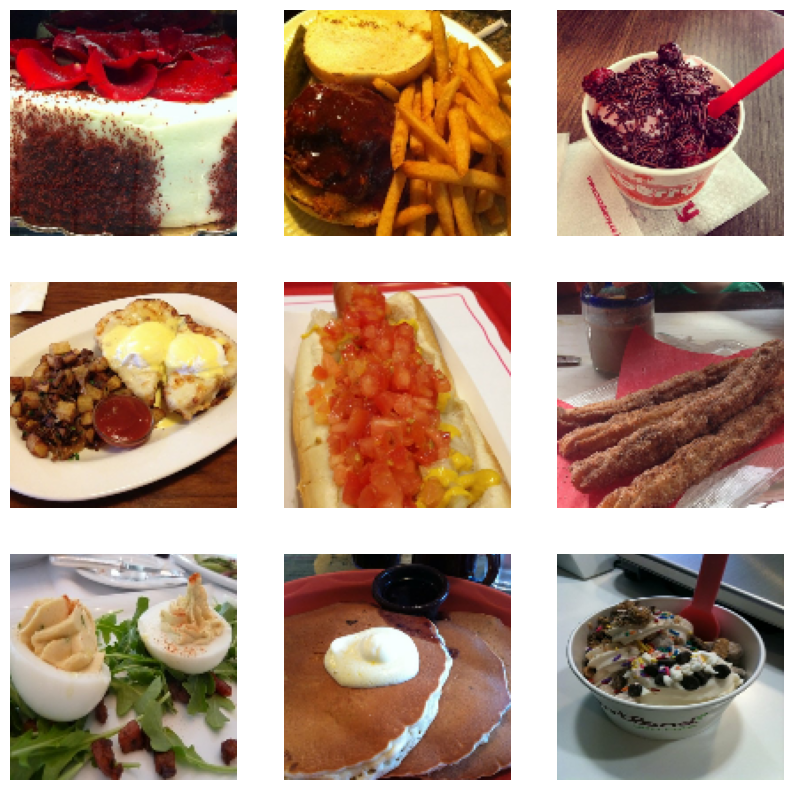

In [16]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

In [17]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)>